In [3]:
%cd /home/hotson/kaggle_work/recodai-luc-scientific-image-forgery-detection/

/home/hotson/kaggle_work/recodai-luc-scientific-image-forgery-detection


In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, List, Tuple, Any
import timm
from torchvision import transforms
from tqdm import tqdm
from pathlib import Path
from __future__ import annotations
import random
from PIL import Image

from dataclasses import dataclass
from transformers import AutoModel
import math
import os
import cv2

# Config

In [8]:
class Config:
    SUBMISSION_MODE = len(
        os.listdir("test_images/")
    ) > 1
    TRAIN_IMG_DIR = "train_images/forged/"
    TEST_IMG_DIR = "test_images"
    SUPPLEMENTAL_IMG_DIR = "supplemental_images"
    DINO_PATH = "/kaggle/input/dinov2/pytorch/base/1"
    SUBMISSION_DF = "sample_submission.csv"
    SEED = 42

def set_seed(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(Config.SEED)

# Models

### DinoSegModel

In [9]:
class DinoSegModel(nn.Module):
    """
    Simple ViT-DINO backbone with a lightweight upsampling head for binary segmentation.
    """

    def __init__(
        self,
        model_name: str = "vit_base_patch16_224.dino",
        pretrained: bool = True,
        num_classes: int = 1,
        img_size: int | None = None,
    ):
        super().__init__()
        self.img_size = img_size
        create_kwargs = {}
        if img_size is not None:
            create_kwargs["img_size"] = img_size
        self.backbone = timm.create_model(model_name, pretrained=pretrained, **create_kwargs)
        # Remove classifier if present.
        if hasattr(self.backbone, "reset_classifier"):
            self.backbone.reset_classifier(0)
        self.num_classes = num_classes

        patch_size = getattr(getattr(self.backbone, "patch_embed", None), "patch_size", (16, 16))
        self.patch_size = patch_size[0] if isinstance(patch_size, (tuple, list)) else int(patch_size)
        embed_dim = getattr(self.backbone, "num_features", 768)

        self.decode_head = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(embed_dim // 2, num_classes, kernel_size=1),
        )

    def _extract_tokens(self, feats: Any) -> torch.Tensor:
        """
        Normalize different timm forward_features outputs to a token tensor (B, N, C).
        """
        x = feats
        if isinstance(x, dict):
            for key in ("x", "last_hidden_state", "tokens"):
                if key in x:
                    x = x[key]
                    break
            else:
                x = next(iter(x.values()))
        if isinstance(x, (list, tuple)):
            x = x[-1]
        return x

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        B, _, H, W = images.shape
        feats = self.backbone.forward_features(images)
        tokens = self._extract_tokens(feats)

        if tokens.shape[1] == (H // self.patch_size) * (W // self.patch_size) + 1:
            cls_token = tokens[:, 0, :]
        else:
            cls_token = tokens.mean(dim=1)

        # Drop class token if present.
        if tokens.shape[1] == (H // self.patch_size) * (W // self.patch_size) + 1:
            tokens = tokens[:, 1:, :]

        h_tokens = H // self.patch_size
        w_tokens = W // self.patch_size
        tokens = tokens.view(B, h_tokens, w_tokens, -1).permute(0, 3, 1, 2).contiguous()
        mask_logits = self.decode_head(tokens)
        mask_logits = F.interpolate(mask_logits, size=(H, W), mode="bilinear", align_corners=False)
        return mask_logits


### Dinov2Unet

In [10]:

class ConvBNReLU(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, k: int = 3, p: int = 1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class DecoderBlock(nn.Module):
    """
    UNet-style decoder block:
    - upsample x
    - concat with skip
    - convs
    """

    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.conv1 = ConvBNReLU(in_ch + skip_ch, out_ch, k=3, p=1)
        self.conv2 = ConvBNReLU(out_ch, out_ch, k=3, p=1)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, size=skip.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


@dataclass
class DinoV2Config:
    model_id: str = "facebook/dinov2-base"
    out_indices: Tuple[int, int, int, int] = (2, 5, 8, 11)
    patch_size: int = 14


class DinoV2HookBackbone(nn.Module):
    """
    DINOv2 backbone that returns 4 feature maps from intermediate blocks.
    Each feature map is (B, C, H/ps, W/ps).
    """

    def __init__(self, cfg: DinoV2Config):
        super().__init__()
        self.cfg = cfg
        self.encoder = AutoModel.from_pretrained(cfg.model_id, local_files_only=True)

        self.hidden_size = int(self.encoder.config.hidden_size)

        self._feats: Dict[int, torch.Tensor] = {}
        self._out_indices = set(cfg.out_indices)

        blocks = self.encoder.encoder.layer
        for i, blk in enumerate(blocks):
            blk.register_forward_hook(self._make_hook(i))

    def _make_hook(self, idx: int):
        def hook(module, inp, out):
            # HF blocks can return tuples; keep the hidden states tensor.
            if isinstance(out, (list, tuple)):
                out = out[0]
            self._feats[idx] = out

        return hook

    @torch.no_grad()
    def freeze(self) -> None:
        for p in self.encoder.parameters():
            p.requires_grad = False

    def unfreeze_last_blocks(self, n_last: int = 4) -> None:
        blocks = self.encoder.encoder.layer
        n = len(blocks)
        for i, blk in enumerate(blocks):
            req = i >= (n - n_last)
            for p in blk.parameters():
                p.requires_grad = req

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:
        self._feats = {}
        _ = self.encoder(pixel_values=x, return_dict=True, output_hidden_states=False)

        b, _, h, w = x.shape
        gh = h // self.cfg.patch_size
        gw = w // self.cfg.patch_size

        feats: List[torch.Tensor] = []
        for idx in self.cfg.out_indices:
            t = self._feats[idx]
            t = t[:, 1:, :]
            fmap = t.transpose(1, 2).contiguous().view(b, self.hidden_size, gh, gw)
            feats.append(fmap)

        return feats


class DinoV2UNet(nn.Module):
    """
    UNet-like decoder operating on same-resolution token maps (gh x gw),
    using intermediate depth features as "skip" connections.
    """

    def __init__(
        self,
        dinov2_id: str = "facebook/dinov2-base",
        out_indices: Tuple[int, int, int, int] = (2, 5, 8, 11),
        patch_size: int = 14,
        dec_channels: Tuple[int, int, int, int] = (512, 256, 192, 128),
        out_classes: int = 1,
    ):
        super().__init__()
        cfg = DinoV2Config(model_id=dinov2_id, out_indices=out_indices, patch_size=patch_size)
        self.backbone = DinoV2HookBackbone(cfg)
        c = self.backbone.hidden_size

        self.proj1 = nn.Conv2d(c, dec_channels[3], kernel_size=1)
        self.proj2 = nn.Conv2d(c, dec_channels[2], kernel_size=1)
        self.proj3 = nn.Conv2d(c, dec_channels[1], kernel_size=1)
        self.proj4 = nn.Conv2d(c, dec_channels[0], kernel_size=1)

        self.dec3 = DecoderBlock(in_ch=dec_channels[0], skip_ch=dec_channels[1], out_ch=dec_channels[1])
        self.dec2 = DecoderBlock(in_ch=dec_channels[1], skip_ch=dec_channels[2], out_ch=dec_channels[2])
        self.dec1 = DecoderBlock(in_ch=dec_channels[2], skip_ch=dec_channels[3], out_ch=dec_channels[3])

        self.refine = nn.Sequential(
            ConvBNReLU(dec_channels[3], dec_channels[3], k=3, p=1),
            nn.Dropout2d(0.1),
            nn.Conv2d(dec_channels[3], out_classes, kernel_size=1),
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        feats = self.backbone(images)
        f1, f2, f3, f4 = feats

        s1 = self.proj1(f1)
        s2 = self.proj2(f2)
        s3 = self.proj3(f3)
        x = self.proj4(f4)

        x = self.dec3(x, s3)
        x = self.dec2(x, s2)
        x = self.dec1(x, s1)

        logits_small = self.refine(x)
        logits = F.interpolate(logits_small, size=images.shape[-2:], mode="bilinear", align_corners=False)
        return logits


### Dinov2UperHead

In [11]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, p=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=k, padding=p, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class PSPModule(nn.Module):
    """Pyramid pooling on top-level feature map."""

    def __init__(self, in_ch, out_ch, pool_sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = nn.ModuleList()
        for ps in pool_sizes:
            self.stages.append(
                nn.Sequential(
                    nn.AdaptiveAvgPool2d(ps),
                    nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False),
                    nn.BatchNorm2d(out_ch),
                    nn.ReLU(inplace=True),
                )
            )
        self.bottleneck = ConvBNReLU(in_ch + len(pool_sizes) * out_ch, out_ch, k=3, p=1)

    def forward(self, x):
        h, w = x.shape[-2:]
        priors = [x]
        for stage in self.stages:
            y = stage(x)
            y = F.interpolate(y, size=(h, w), mode="bilinear", align_corners=False)
            priors.append(y)
        x = torch.cat(priors, dim=1)
        return self.bottleneck(x)


class UPerHead(nn.Module):
    """
    UPerNet head: PSP on last feature + FPN fusion.
    feats: list of feature maps [C2, C3, C4, C5] (low->high level)
    """

    def __init__(self, in_channels_list, channels=256, num_classes=1):
        super().__init__()
        assert len(in_channels_list) == 4, "Expect 4 feature levels"
        self.lateral_convs = nn.ModuleList([nn.Conv2d(c, channels, 1) for c in in_channels_list])
        self.fpn_convs = nn.ModuleList([ConvBNReLU(channels, channels) for _ in in_channels_list])

        self.psp = PSPModule(channels, channels)

        self.fuse = ConvBNReLU(channels * 4, channels)
        self.classifier = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, feats):
        laterals = [lat(f) for lat, f in zip(self.lateral_convs, feats)]

        laterals[-1] = self.psp(laterals[-1])

        for i in range(2, -1, -1):
            up = F.interpolate(laterals[i + 1], size=laterals[i].shape[-2:], mode="bilinear", align_corners=False)
            laterals[i] = laterals[i] + up

        outs = [fpn(lat) for fpn, lat in zip(self.fpn_convs, laterals)]

        target_size = outs[0].shape[-2:]
        outs = [outs[0]] + [F.interpolate(o, size=target_size, mode="bilinear", align_corners=False) for o in outs[1:]]
        x = self.fuse(torch.cat(outs, dim=1))
        return self.classifier(x)


class DinoV2Backbone(nn.Module):
    """
    Extract intermediate block tokens from DINOv2 and reshape to feature maps.
    """

    def __init__(self, model_id: str, out_indices=(2, 5, 8, 11)):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_id, local_files_only=True)
        self.out_indices = set(out_indices)

        self._features = {}
        for i, blk in enumerate(self.encoder.encoder.layer):
            blk.register_forward_hook(self._make_hook(i))

        self.hidden_size = self.encoder.config.hidden_size
        self.patch_size = 14

    def _make_hook(self, idx):
        def hook(module, inp, out):
            # HF blocks can return tuples; keep the hidden states tensor.
            if isinstance(out, (list, tuple)):
                out = out[0]
            self._features[idx] = out

        return hook

    def forward(self, x):
        self._features = {}
        _ = self.encoder(pixel_values=x, output_hidden_states=False, return_dict=True)
        feats = []
        b, _, h, w = x.shape

        gh = h // self.patch_size
        gw = w // self.patch_size

        for idx in sorted(self.out_indices):
            t = self._features[idx]
            t = t[:, 1:, :]
            fmap = t.transpose(1, 2).contiguous().view(b, self.hidden_size, gh, gw)
            feats.append(fmap)

        return feats


class DinoV2_UPerNet(nn.Module):
    def __init__(self, dinov2_id: str, num_classes=1, uper_channels=256, out_indices=(2, 5, 8, 11)):
        super().__init__()
        self.backbone = DinoV2Backbone(dinov2_id, out_indices=out_indices)
        in_list = [self.backbone.hidden_size] * 4
        self.decode_head = UPerHead(in_list, channels=uper_channels, num_classes=num_classes)

    def forward(self, images):
        feats = self.backbone(images)
        logits_small = self.decode_head(feats)
        logits = F.interpolate(logits_small, size=images.shape[-2:], mode="bilinear", align_corners=False)
        return logits

# Submission Utils

In [12]:
import json

import numba
import numpy as np
from numba import types
import numpy.typing as npt
import pandas as pd
import scipy.optimize


class ParticipantVisibleError(Exception):
    pass


@numba.jit(nopython=True)
def _rle_encode_jit(x: npt.NDArray, fg_val: int = 1) -> list[int]:
    """Numba-jitted RLE encoder."""
    dots = np.where(x.T.flatten() == fg_val)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def rle_encode(masks: list[npt.NDArray], fg_val: int = 1) -> str:
    """
    Adapted from contrails RLE https://www.kaggle.com/code/inversion/contrails-rle-submission
    Args:
        masks: list of numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encodings as a string, with each RLE JSON-encoded and separated by a semicolon.
    """
    return ';'.join([json.dumps(_rle_encode_jit(x, fg_val)) for x in masks])


@numba.njit
def _rle_decode_jit(mask_rle: npt.NDArray, height: int, width: int) -> npt.NDArray:
    """
    s: numpy array of run-length encoding pairs (start, length)
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if len(mask_rle) % 2 != 0:
        # Numba requires raising a standard exception.
        raise ValueError('One or more rows has an odd number of values.')

    starts, lengths = mask_rle[0::2], mask_rle[1::2]
    starts -= 1
    ends = starts + lengths
    for i in range(len(starts) - 1):
        if ends[i] > starts[i + 1]:
            raise ValueError('Pixels must not be overlapping.')
    img = np.zeros(height * width, dtype=np.bool_)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img


def rle_decode(mask_rle: str, shape: tuple[int, int]) -> npt.NDArray:
    """
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """

    mask_rle = json.loads(mask_rle)
    mask_rle = np.asarray(mask_rle, dtype=np.int32)
    starts = mask_rle[0::2]
    if sorted(starts) != list(starts):
        raise ParticipantVisibleError('Submitted values must be in ascending order.')
    try:
        return _rle_decode_jit(mask_rle, shape[0], shape[1]).reshape(shape, order='F')
    except ValueError as e:
        raise ParticipantVisibleError(str(e)) from e


def calculate_f1_score(pred_mask: npt.NDArray, gt_mask: npt.NDArray):
    pred_flat = pred_mask.flatten()
    gt_flat = gt_mask.flatten()

    tp = np.sum((pred_flat == 1) & (gt_flat == 1))
    fp = np.sum((pred_flat == 1) & (gt_flat == 0))
    fn = np.sum((pred_flat == 0) & (gt_flat == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    if (precision + recall) > 0:
        return 2 * (precision * recall) / (precision + recall)
    else:
        return 0


def calculate_f1_matrix(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Parameters:
    pred_masks (np.ndarray):
            First dimension is the number of predicted instances.
            Each instance is a binary mask of shape (height, width).
    gt_masks (np.ndarray):
            First dimension is the number of ground truth instances.
            Each instance is a binary mask of shape (height, width).
    """

    num_instances_pred = len(pred_masks)
    num_instances_gt = len(gt_masks)
    f1_matrix = np.zeros((num_instances_pred, num_instances_gt))

    # Calculate F1 scores for each pair of predicted and ground truth masks
    for i in range(num_instances_pred):
        for j in range(num_instances_gt):
            pred_flat = pred_masks[i].flatten()
            gt_flat = gt_masks[j].flatten()
            f1_matrix[i, j] = calculate_f1_score(pred_mask=pred_flat, gt_mask=gt_flat)

    if f1_matrix.shape[0] < len(gt_masks):
        # Add a row of zeros to the matrix if the number of predicted instances is less than ground truth instances
        f1_matrix = np.vstack((f1_matrix, np.zeros((len(gt_masks) - len(f1_matrix), num_instances_gt))))

    return f1_matrix


def oF1_score(pred_masks: list[npt.NDArray], gt_masks: list[npt.NDArray]):
    """
    Calculate the optimal F1 score for a set of predicted masks against
    ground truth masks which considers the optimal F1 score matching.
    This function uses the Hungarian algorithm to find the optimal assignment
    of predicted masks to ground truth masks based on the F1 score matrix.
    If the number of predicted masks is less than the number of ground truth masks,
    it will add a row of zeros to the F1 score matrix to ensure that the dimensions match.

    Parameters:
    pred_masks (list of np.ndarray): List of predicted binary masks.
    gt_masks (np.ndarray): Array of ground truth binary masks.
    Returns:
    float: Optimal F1 score.
    """
    f1_matrix = calculate_f1_matrix(pred_masks, gt_masks)

    # Find the best matching between predicted and ground truth masks
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-f1_matrix)
    # The linear_sum_assignment discards excess predictions so we need a separate penalty.
    excess_predictions_penalty = len(gt_masks) / max(len(pred_masks), len(gt_masks))
    return np.mean(f1_matrix[row_ind, col_ind]) * excess_predictions_penalty


def evaluate_single_image(label_rles: str, prediction_rles: str, shape_str: str) -> float:
    shape = json.loads(shape_str)
    label_rles = [rle_decode(x, shape=shape) for x in label_rles.split(';')]
    prediction_rles = [rle_decode(x, shape=shape) for x in prediction_rles.split(';')]
    return oF1_score(prediction_rles, label_rles)


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Args:
        solution (pd.DataFrame): The ground truth DataFrame.
        submission (pd.DataFrame): The submission DataFrame.
        row_id_column_name (str): The name of the column containing row IDs.
    Returns:
        float

    Examples
    --------
    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['authentic', 'authentic', 'authentic'], 'shape': ['authentic', 'authentic', 'authentic']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    1.0

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 103]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.9983739837398374

    >>> solution = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102];[300, 100]', '[101, 102]', '[101, 102]'], 'shape': ['[720, 960]', '[720, 960]', '[720, 960]']})
    >>> submission = pd.DataFrame({'row_id': [0, 1, 2], 'annotation': ['[101, 102]', '[101, 102]', '[101, 102]']})
    >>> score(solution.copy(), submission.copy(), row_id_column_name='row_id')
    0.8333333333333334
    """
    df = solution
    df = df.rename(columns={'annotation': 'label'})

    df['prediction'] = submission['annotation']
    # Check for correct 'authentic' label
    authentic_indices = (df['label'] == 'authentic') | (df['prediction'] == 'authentic')
    df['image_score'] = ((df['label'] == df['prediction']) & authentic_indices).astype(float)

    df.loc[~authentic_indices, 'image_score'] = df.loc[~authentic_indices].apply(
        lambda row: evaluate_single_image(row['label'], row['prediction'], row['shape']), axis=1
    )
    return float(np.mean(df['image_score']))

# Inference

In [14]:
def create_dataframe(img_dir: Path):
    if os.path.exists("analysis/area_splits/val_fold0.csv"):
        return pd.read_csv("analysis/area_splits/val_fold0.csv")
    rows = []
    for img_path in img_dir.glob("*"):
        case_id = img_path.stem
        rows.append((case_id, img_path))
    return pd.DataFrame(
        data = rows,
        columns = ["case_id", "image_path"]
    )

# Dataset

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int):
        self.df = df.reset_index(drop=True)
        self.img_size = img_size
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.img_transform = transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                self.to_tensor,
                self.normalize,
            ]
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]

        case_id = row["case_id"]        
        image_path = row["image_path"]
        with open(image_path, "rb") as f:
            img = Image.open(f).convert("RGB")
        orig_size = img.size  # (W,H)
        img_t = self.img_transform(img)
        return img_t, case_id, orig_size, str(image_path)

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader, Subset
from torch.utils.data.dataloader import default_collate
import numpy as np
import torch
import cv2
import math
import random
from PIL import Image
from tqdm import tqdm
import pandas as pd

def infer(
    weight_path: Path,
    arch: str,
    model_name: str,
    dinov2_id: str,
    img_size: int,
    threshold: float,
    device: torch.device,
    img_dir: str,
    samples: bool,
):
    if not weight_path.exists():
        raise FileNotFoundError(f"Missing weights: {weight_path}")

    # -------------------------
    # Load checkpoint
    # -------------------------
    state = torch.load(weight_path, map_location=device)
    model_state = state["model_state"]

    def infer_img_size_from_state(state_dict: dict, fallback: int) -> int:
        pos_embed = state_dict.get("backbone.pos_embed")
        patch_weight = state_dict.get("backbone.patch_embed.proj.weight")
        if pos_embed is None or patch_weight is None:
            return fallback

        tokens = pos_embed.shape[1]
        grid_tokens = tokens - 1
        grid = int(math.sqrt(grid_tokens))
        if grid * grid != grid_tokens:
            return fallback

        patch = int(patch_weight.shape[-1])
        return grid * patch

    if arch == "dino_seg":
        inferred_img_size = infer_img_size_from_state(model_state, img_size)
        if inferred_img_size != img_size:
            print(f"Adjusting img_size from {img_size} to {inferred_img_size} based on checkpoint pos_embed.")
            img_size = inferred_img_size
    else:
        if img_size % 14 != 0:
            raise ValueError(f"{arch} requires img_size divisible by 14 (Dinov2 patch size).")

    # -------------------------
    # Dataset / loader
    # -------------------------
    df = create_dataframe(img_dir)
    dataset = InferenceDataset(df, img_size=img_size)

    if samples is not None and Config.SUBMISSION_MODE == False:
        if samples <= 0:
            raise ValueError("--samples must be a positive integer.")
        total = len(dataset)
        pick = min(samples, total)
        indices = random.sample(range(total), k=pick)
        dataset = Subset(dataset, indices)

    # IMPORTANT: custom collate to preserve orig_sizes as list of (W,H)
    def collate_fn(batch):
        images, case_ids, orig_sizes, image_paths = zip(*batch)
        images = default_collate(images)  # stacks tensors
        # keep these as simple Python lists (no weird transpose)
        return images, list(case_ids), list(orig_sizes), list(image_paths)

    loader = DataLoader(
        dataset,
        batch_size=2,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=collate_fn,
    )

    # -------------------------
    # Build model
    # -------------------------
    if arch == "dino_seg":
        model = DinoSegModel(model_name=model_name, pretrained=False, img_size=img_size).to(device)
    elif arch == "dinov2_uperhead":
        model = DinoV2_UPerNet(dinov2_id=Config.DINO_PATH, num_classes=1).to(device)
    elif arch == "dinov2_unet":
        model = DinoV2UNet(dinov2_id=Config.DINO_PATH, out_classes=1).to(device)
    else:
        raise ValueError(f"Unknown arch: {arch}")

    model.load_state_dict(model_state)
    model.eval()
    print("[INFO] Loaded model")

    # -------------------------
    # Helpers
    # -------------------------
    def normalize_case_id(raw) -> int | str:
        if torch.is_tensor(raw):
            raw = raw.item()
        return int(raw) if isinstance(raw, (np.integer, int)) else str(raw)

    def enhanced_adaptive_mask(prob: np.ndarray, alpha_grad=0.45):
        prob = np.asarray(prob, dtype=np.float32)
        if prob.ndim == 3:
            prob = prob[..., 0]

        gx = cv2.Sobel(prob, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(prob, cv2.CV_32F, 0, 1, ksize=3)
        grad_mag = np.sqrt(gx**2 + gy**2)
        grad_norm = grad_mag / (grad_mag.max() + 1e-6)

        enhanced = (1 - alpha_grad) * prob + alpha_grad * grad_norm
        enhanced = cv2.GaussianBlur(enhanced, (3, 3), 0)

        thr = float(np.mean(enhanced) + 0.3 * np.std(enhanced))
        mask = (enhanced > thr).astype(np.uint8)

        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
        return mask, thr

    def finalize_mask(prob: np.ndarray, orig_size_wh: tuple[int, int]):
        # orig_size_wh MUST be (W,H)
        mask, thr = enhanced_adaptive_mask(prob)
        w, h = orig_size_wh
        mask = cv2.resize(mask, (int(w), int(h)), interpolation=cv2.INTER_NEAREST)
        return mask, thr

    def apply_overlay(img_np: np.ndarray, mask01: np.ndarray, color=(255, 0, 0), alpha=0.5):
        overlay = img_np.copy()
        mask_bool = mask01.astype(bool)
        overlay[mask_bool] = (
            alpha * np.array(color, dtype=np.float32)
            + (1 - alpha) * overlay[mask_bool].astype(np.float32)
        ).astype(np.uint8)
        return overlay

    # -------------------------
    # Inference
    # -------------------------
    submission_rows = []

    with torch.no_grad():
        for images, case_ids, orig_sizes, image_paths in tqdm(loader, desc="Predicting masks"):
            images = images.to(device, non_blocking=True)
            out = model(images)

            logits = out if torch.is_tensor(out) else out[0]
            probs = torch.sigmoid(logits).float().cpu().numpy()  # (B,1,H,W) usually

            for i, case_id in enumerate(case_ids):
                case_id_val = normalize_case_id(case_id)

                # orig_sizes[i] is now a clean Python tuple (W,H)
                orig_w, orig_h = orig_sizes[i]
                mask, thr = finalize_mask(probs[i, 0], (orig_w, orig_h))

                pred_bin = (mask > 0).astype(np.uint8)  # 0/1

                if Config.SUBMISSION_MODE == False:
                    import matplotlib.pyplot as plt

                    # Load image for visualization
                    with open(image_paths[i], "rb") as f:
                        orig_img = Image.open(f).convert("RGB")
                    orig_np = np.array(orig_img)
                    vis_w, vis_h = orig_img.size  # (W,H)

                    # Ensure pred matches visualization image size (safety)
                    if pred_bin.shape[:2] != (vis_h, vis_w):
                        pred_bin_vis = cv2.resize(pred_bin, (vis_w, vis_h), interpolation=cv2.INTER_NEAREST)
                    else:
                        pred_bin_vis = pred_bin

                    # ground-truth mask
                    mask_path = (
                        image_paths[i]
                        .replace("train_images", "train_masks")
                        .replace("supplemental_images", "supplemental_masks")
                        .replace(".png", ".npy")
                        .replace("/forged", "")
                    )

                    arr = np.load(mask_path, allow_pickle=True)
                    if arr.ndim == 3:
                        arr = arr.max(axis=0)
                    gt_mask = (arr > 0).astype(np.uint8)

                    # Ensure GT matches visualization image size
                    if gt_mask.shape[:2] != (vis_h, vis_w):
                        gt_mask_vis = cv2.resize(gt_mask, (vis_w, vis_h), interpolation=cv2.INTER_NEAREST)
                    else:
                        gt_mask_vis = gt_mask

                    pred_mask_rgb = (pred_bin_vis[..., None] * 255).repeat(3, axis=2).astype(np.uint8)
                    gt_mask_rgb = (gt_mask_vis[..., None] * 255).repeat(3, axis=2).astype(np.uint8)
                    print("PIL size (W,H):", orig_img.size)
                    print("np shape (H,W,C):", orig_np.shape)
                    print(case_id_val, orig_np.shape, pred_mask_rgb.shape, gt_mask_rgb.shape)
                    pred_overlay = apply_overlay(orig_np, pred_bin_vis, color=(255, 0, 0))
                    gt_overlay = apply_overlay(orig_np, gt_mask_vis, color=(0, 255, 0))

                    fig, axes = plt.subplots(1, 5, figsize=(18, 4))
                    titles = [f"Input_{case_id_val}", "Pred mask", "GT mask", "Pred overlay", "GT overlay"]
                    imgs = [orig_np, pred_mask_rgb, gt_mask_rgb, pred_overlay, gt_overlay]
                    for ax, img, title in zip(axes, imgs, titles):
                        ax.imshow(img)
                        ax.set_title(title)
                        ax.axis("off")
                    plt.tight_layout()
                    plt.show()

                # Submission row
                if pred_bin.sum() == 0:
                    submission_rows.append({"case_id": str(case_id_val), "annotation": "authentic"})
                else:
                    # If your rle_encode expects 2D mask, use rle_encode(pred_bin)
                    # If it expects list like your current code, keep as-is.
                    submission_rows.append({"case_id": str(case_id_val), "annotation": rle_encode([pred_bin])})

    submission_df = pd.DataFrame(submission_rows)
    submission_df["case_id"] = submission_df["case_id"].astype(str)
    submission_df.to_csv("submission.csv", index=False)
    return submission_df


[INFO] Loaded model


Predicting masks:   0%|          | 0/5 [00:00<?, ?it/s]

PIL size (W,H): (1600, 1200)
np shape (H,W,C): (1200, 1600, 3)
38456 (1200, 1600, 3) (1200, 1600, 3) (1200, 1600, 3)


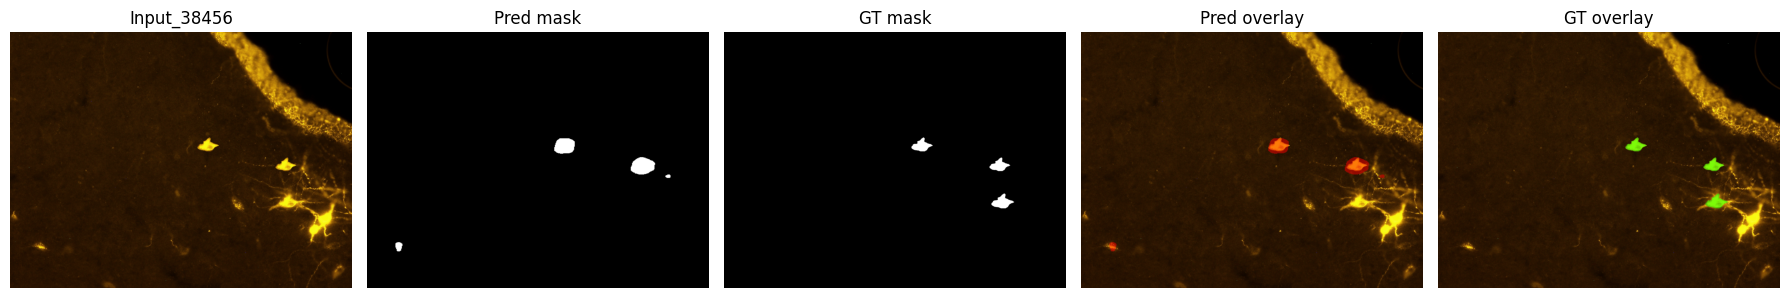

PIL size (W,H): (512, 512)
np shape (H,W,C): (512, 512, 3)
27312 (512, 512, 3) (512, 512, 3) (512, 512, 3)


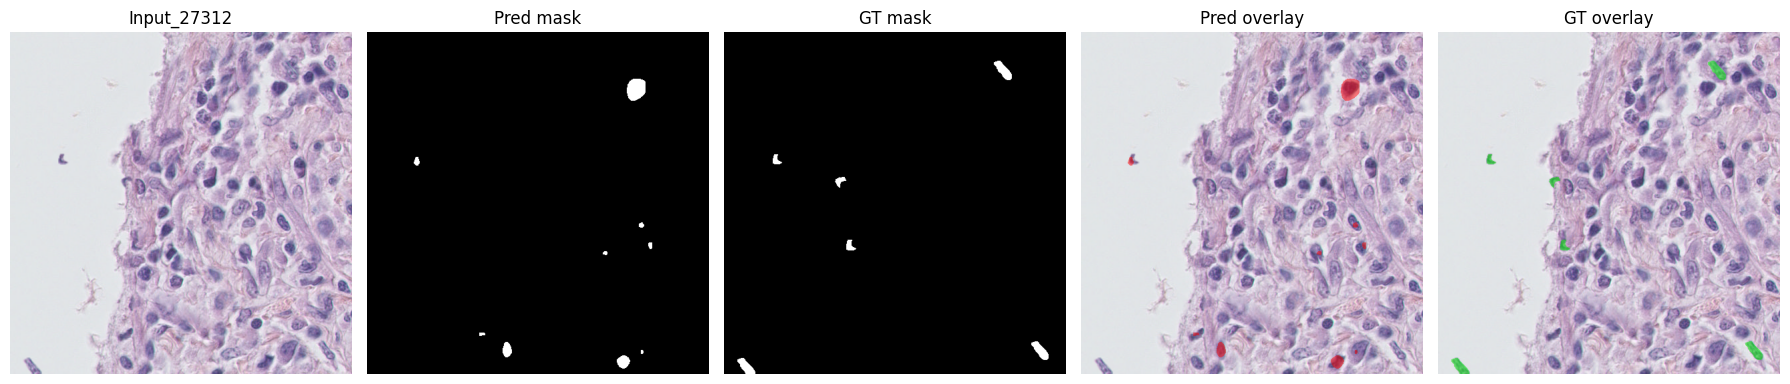

Predicting masks:  20%|██        | 1/5 [00:02<00:10,  2.72s/it]

PIL size (W,H): (1599, 1225)
np shape (H,W,C): (1225, 1599, 3)
4221 (1225, 1599, 3) (1225, 1599, 3) (1225, 1599, 3)


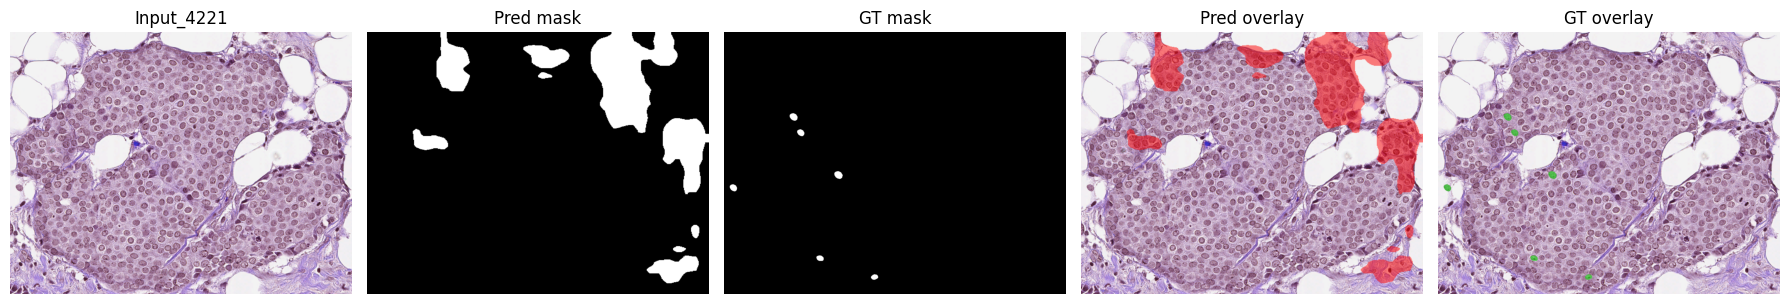

PIL size (W,H): (320, 256)
np shape (H,W,C): (256, 320, 3)
58142 (256, 320, 3) (256, 320, 3) (256, 320, 3)


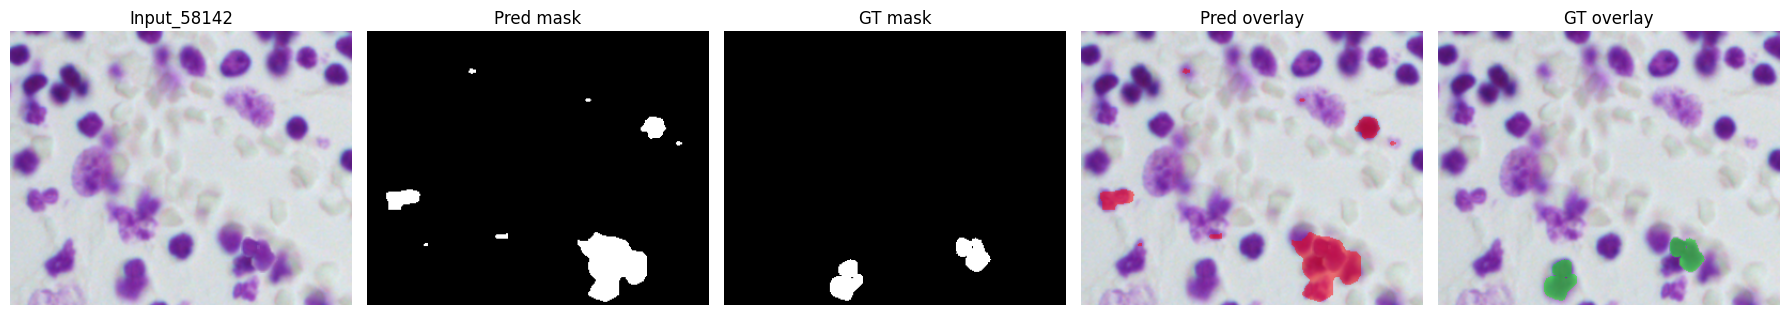

Predicting masks:  40%|████      | 2/5 [00:04<00:05,  1.92s/it]

PIL size (W,H): (512, 550)
np shape (H,W,C): (550, 512, 3)
34992 (550, 512, 3) (550, 512, 3) (550, 512, 3)


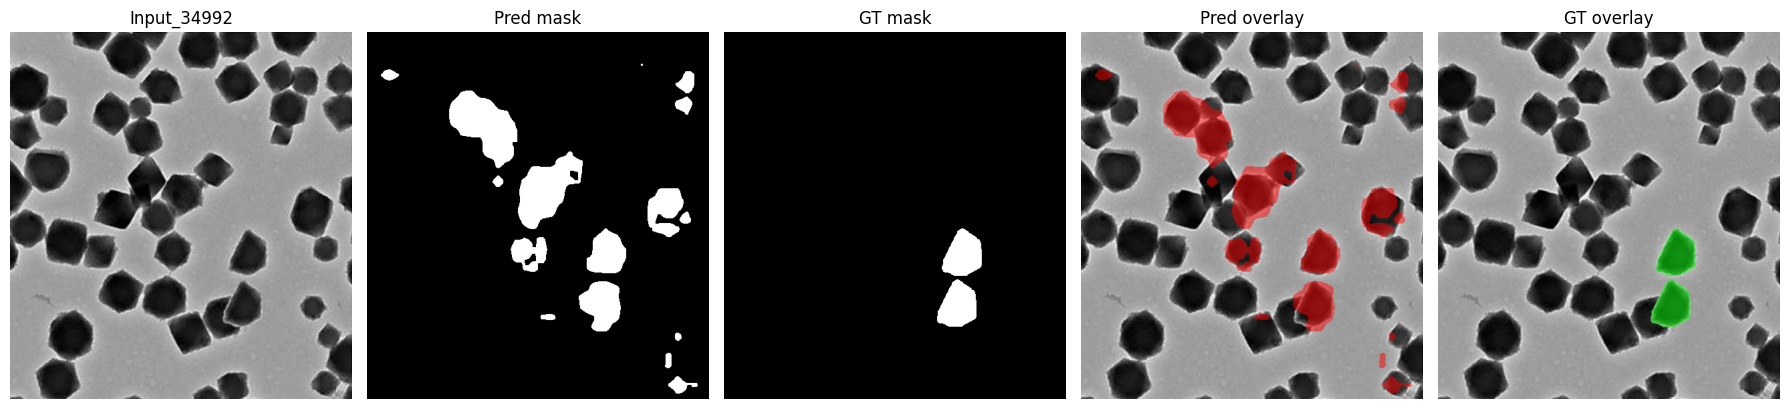

PIL size (W,H): (696, 520)
np shape (H,W,C): (520, 696, 3)
24300 (520, 696, 3) (520, 696, 3) (520, 696, 3)


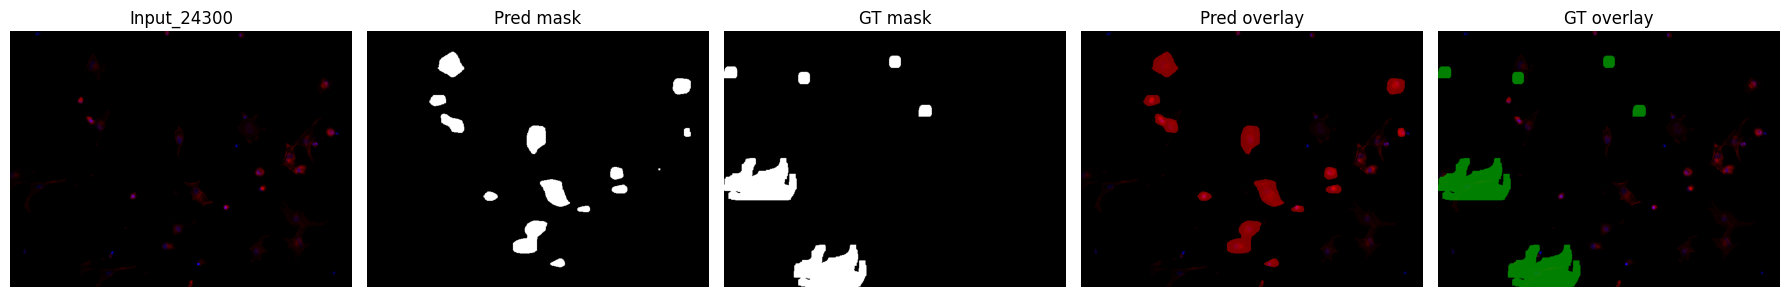

Predicting masks:  60%|██████    | 3/5 [00:04<00:02,  1.44s/it]

PIL size (W,H): (256, 256)
np shape (H,W,C): (256, 256, 3)
29679 (256, 256, 3) (256, 256, 3) (256, 256, 3)


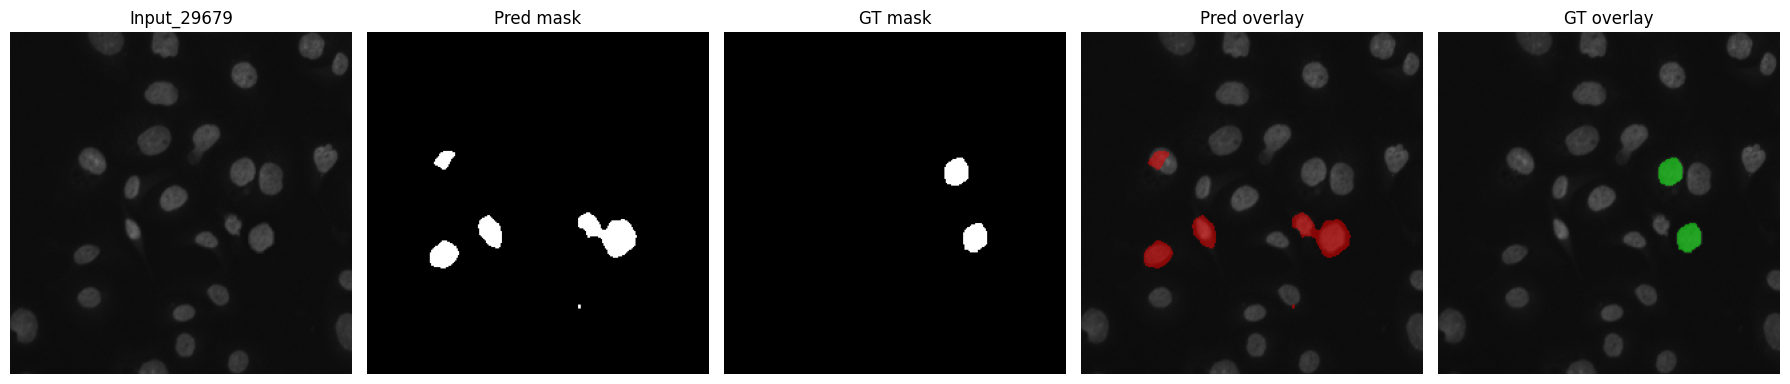

PIL size (W,H): (541, 105)
np shape (H,W,C): (105, 541, 3)
40354 (105, 541, 3) (105, 541, 3) (105, 541, 3)


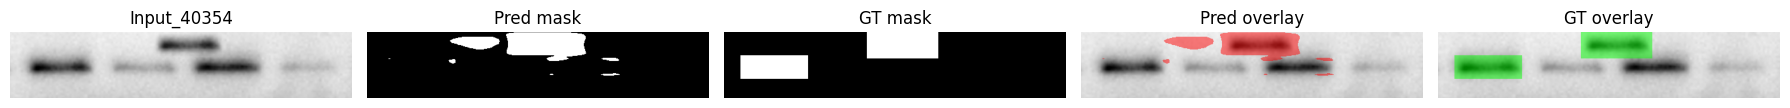

Predicting masks:  80%|████████  | 4/5 [00:05<00:01,  1.11s/it]

PIL size (W,H): (1600, 1200)
np shape (H,W,C): (1200, 1600, 3)
19554 (1200, 1600, 3) (1200, 1600, 3) (1200, 1600, 3)


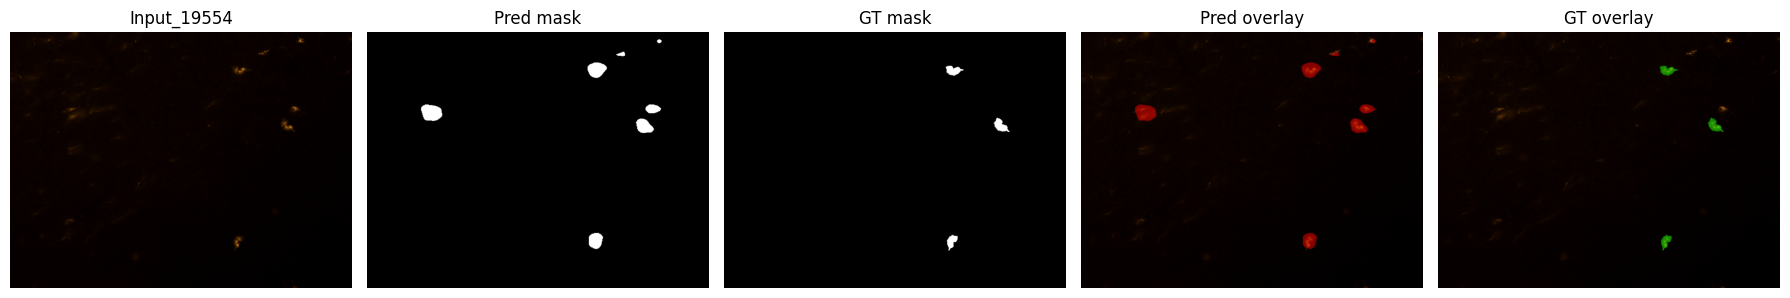

PIL size (W,H): (768, 512)
np shape (H,W,C): (512, 768, 3)
29475 (512, 768, 3) (512, 768, 3) (512, 768, 3)


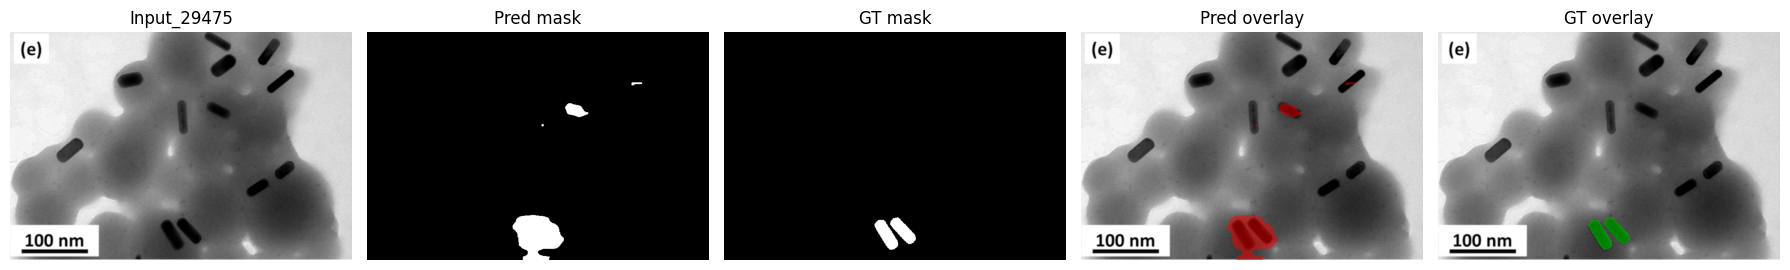

Predicting masks: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


,case_id,annotation
0,38456,"[160592, 20, 161792, 20, 162992, 20, 164189, 3..."
1,27312,"[36035, 3, 36544, 7, 37053, 11, 37564, 13, 380..."
2,4221,"[262617, 13, 263842, 13, 265067, 13, 266289, 4..."
3,58142,"[4760, 6, 5016, 8, 5271, 17, 5527, 17, 5783, 1..."
4,34992,"[11615, 4, 12165, 4, 12714, 6, 13262, 9, 13811..."
5,24300,"[66182, 5, 66702, 5, 67219, 10, 67736, 14, 682..."
6,29679,"[12198, 8, 12452, 12, 12707, 13, 12898, 2, 129..."
7,40354,"[3614, 1, 3719, 1, 3824, 1, 13592, 1, 13696, 4..."
8,19554,"[303958, 16, 305158, 16, 306358, 16, 307553, 3..."
9,29475,"[167859, 7, 168369, 11, 168881, 11, 169391, 14..."


In [90]:
if Config.SUBMISSION_MODE:
    img_dir = Config.TEST_IMG_DIR
else:
    img_dir = Config.TRAIN_IMG_DIR
    # img_dir = Config.SUPPLEMENTAL_IMG_DIR
    
sub_df = infer(
    weight_path = Path(
        "/kaggle/input/recodai-dinov2unet-no-posw/vit_base_patch14_dinov2.lvd142m_fold0.pt"
    ),
    arch = "dinov2_uperhead",
    model_name = "vit_base_patch14_dinov2.lvd142m",
    dinov2_id = "facebook/dinov2-base",
    img_size = 532,
    threshold = 0.2,
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),
    img_dir = Path(img_dir),
    samples = 10,
)
sub_df